In [1]:
import numpy as np
import qutip as qt
from qutip import Qobj
import matplotlib.pyplot as plt

# Define the parameters of the Ising model
def calc_plaquette_Ham(J_values, h_values, gamma):
    N = len(h_values)  # Number of spins

    # Create the spin operators for N spins
    spin_operators= [qt.sigmaz() for _ in range(N)]
    spin_interactors = [qt.sigmaz() for _ in range(N)]

    # Create the Hamiltonian for the Ising model in one tile
    Imatrix = qt.qeye(2) 
    H = qt.Qobj()
    Hint = qt.Qobj()
    Htot = qt.Qobj()


    for i in range(N):

        spin_temp= [qt.qeye(2) for _ in range(N)]
        for j in range(N):
            if i == j:
                spin_temp[j] = spin_operators[i]
            
        spin_kronecker = qt.tensor(spin_temp[0], spin_temp[1], spin_temp[2], spin_temp[3])    
        #spin_kronecker = qt.tensor(spin_temp[2], spin_temp[3], spin_temp[4], spin_temp[5], spin_temp[0], spin_temp[1])
        H += h_values[i] * spin_kronecker

    Hint =  -J_values * qt.tensor(spin_interactors[0], spin_interactors[1], spin_interactors[2], spin_interactors[3])
    
    #Hint =  -J_values * qt.tensor(spin_interactors[2], spin_interactors[3], spin_interactors[4], spin_interactors[5], spin_interactors[0], Imatrix)
    #Hint += -J_values * qt.tensor(spin_interactors[2], spin_interactors[3], spin_interactors[4], spin_interactors[5], Imatrix, spin_interactors[1])

    #Adding noise to the Hamiltonian
    #noise = gamma * np.random.normal(size=H.shape)
    noise = gamma * np.random.randn(*H.shape)
    noise_qobj = Qobj(noise, dims=H.dims)    
    #print(H.shape)
    Htot = H + Hint + noise_qobj

    return Htot

In [ ]:
J_values = 2 # Coupling strength
#h_values = np.array([-0.3, 0.3, -0.3 , 0.3])  # Magnetic field strengths
h_values = np.array([0.3, -0.3, 0.3 , -0.3])  # Magnetic field strengths
#h_values = np.array([-0.6, -0.6, 0.3, -0.3, 0.3 , -0.3])  # Magnetic field strengths

HamiltonVal = qt.Qobj()
HamiltonVal = calc_plaquette_Ham(J_values, h_values, 0.1)

eigenenergies, eigenstate = HamiltonVal.eigenstates(HamiltonVal)

bracket = []
stateSize = 2 ** len(h_values)
for i in range(stateSize):
    ket1 = qt.basis(stateSize, i)  # input ket calculation
    bracket.append(HamiltonVal.matrix_element(ket1,ket1))


vector = np.real(bracket)
local_minima = np.r_[True, vector[1:] < vector[:-1]] & np.r_[vector[:-1] < vector[1:], True]
minima_indices = np.where(local_minima)[0]
#print(minima_indices)
total_energy = 0
binary_string = []
for j in minima_indices:
    state = int(j)
    binary_string.append(format(state, '0{length}b'.format(length=4)))

# Calculating probability
ground_energy = eigenenergies[0]
print("Ground energy value of the Hamiltonian:", ground_energy)
vector_with_min = [x - ground_energy for x in vector]

energies = []
for j in minima_indices:
    energies.append(vector[j])

for j in minima_indices:
    total_energy += 1 / vector_with_min[j]

state_prob = []
for j in minima_indices:
    temp_prob = 1 / (vector_with_min[j] * total_energy)
    state_prob.append(temp_prob)

for i in range(len(minima_indices)):
    print("state: ",binary_string[i], "Energy value: ",vector[minima_indices[i]]) 

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot energies (left y-axis)
ax1.plot(minima_indices, energies, 'b-', label='Energies')
ax1.set_xlabel('States')
ax1.set_xticks(minima_indices)
binary_labels = [bin(val)[2:] for val in minima_indices]
ax1.set_xticklabels(binary_labels)
ax1.set_ylabel('Energies', color='b')
ax1.tick_params('y', colors='b')

# Create a twin axes sharing the x-axis
ax2 = ax1.twinx()

# Plot probabilities (right y-axis)
ax2.plot(minima_indices, state_prob, 'r-', label='Probabilities')
ax2.set_ylabel('Probabilities', color='r')
ax2.tick_params('y', colors='r')
# Display legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Adjust layout and display the figure
ax1.grid()
fig.tight_layout()
plt.xticks(rotation=90,fontsize=6)
plt.show()

## Sweep all the inputs and generate the total energies at the output

Output plot saved to 'simulatedStates.png'.


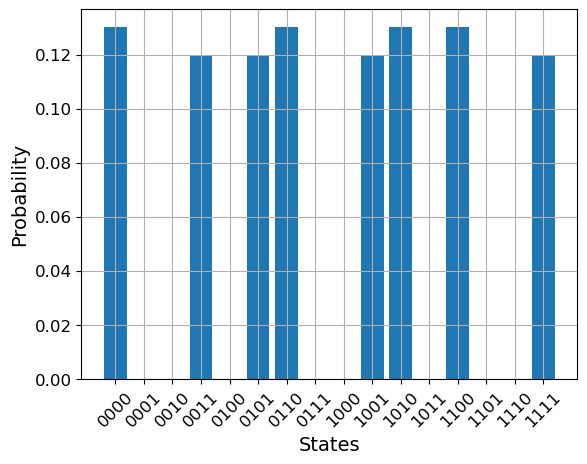

In [15]:
J_values = 1 # Coupling strength
gamma = 0.0#noise strength
HamiltonVal = qt.Qobj()
global_mins = []
minStates = []

Logical_JPO_Num = 4

for i in range(2**Logical_JPO_Num):
    tempval = format(i, '0{length}b'.format(length=Logical_JPO_Num))
    h_values = np.array([0.2, 0.2, 0.2, 0.2])  # Magnetic field strengths
    for j in range(Logical_JPO_Num):
        if tempval[j] == '0':
            h_values[j] = -1 * h_values[j]

    HamiltonVal = calc_plaquette_Ham(J_values, h_values, gamma)
    stateSize = 2 ** len(h_values)
    bracket = []
    for i in range(stateSize):
        ket1 = qt.basis(stateSize, i)  # input ket calculation
        bracket.append(HamiltonVal.matrix_element(ket1,ket1))
    
    vector = np.real(bracket)
    global_min = np.min(vector)
    min_index = np.argmin(vector)
    tempMinval = format(min_index, '0{length}b'.format(length=Logical_JPO_Num))
    global_mins.append(global_min)
    minStates.append(tempMinval)

probability_states = 1 / np.abs(global_mins)


finStates = []
probability_states_fin = []


for i in range(2**Logical_JPO_Num):
    tempStateVal = format(i, '0{length}b'.format(length=Logical_JPO_Num))
    tempStat = 0

    for i in range(len(minStates)):
        if tempStateVal == minStates[i]:
            for j in range(i, len(minStates)):
                if minStates[i] == minStates[j]:
                    tempStat += probability_states [j]

    finStates.append(tempStateVal)
    probability_states_fin.append(tempStat)
        
    
tempSum = 0
for k in range(len(probability_states_fin)):
    tempSum += probability_states_fin[k]

probability_states_fins = probability_states_fin / tempSum

plt.bar(finStates, probability_states_fins, zorder=1)

# Add grid lines
plt.grid(True, zorder=0)

# Set labels and title
plt.xlabel('States', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.xticks(rotation=45)



#plt.title('State Probabilities')

# Save the plot to a PNG file
output_plot = f'simulatedStates.png'
plt.savefig(output_plot, dpi=300, bbox_inches='tight')
print(f"Output plot saved to '{output_plot}'.")

# Show the plot
plt.show()

Output plot saved to 'simulatedStates2.png'.


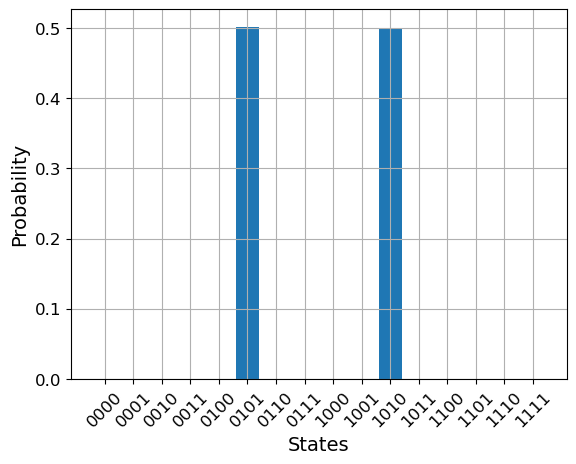

In [7]:
J_values = 5  # Coupling strength
gamma = 0.1#noise strength
HamiltonVal = qt.Qobj()
global_mins = []
minStates = []

Logical_JPO_Num = 4

for i in range(2**Logical_JPO_Num):
    tempval = format(i, '0{length}b'.format(length=Logical_JPO_Num))
    h_values = np.array([0.3, 0.3, 0.3, 0.3])  # Magnetic field strengths
    for j in range(Logical_JPO_Num):
        if i % 2 == 0:
            h_values = np.array([-0.3, 0.3, -0.3, 0.3])
        else :
            h_values = np.array([0.3, -0.3, 0.3, -0.3])

    HamiltonVal = calc_plaquette_Ham(J_values, h_values, gamma)
    stateSize = 2 ** len(h_values)
    bracket = []
    for i in range(stateSize):
        ket1 = qt.basis(stateSize, i)  # input ket calculation
        bracket.append(HamiltonVal.matrix_element(ket1,ket1))
    
    vector = np.real(bracket)
    global_min = np.min(vector)
    min_index = np.argmin(vector)
    tempMinval = format(min_index, '0{length}b'.format(length=Logical_JPO_Num))
    global_mins.append(global_min)
    minStates.append(tempMinval)

probability_states = 1 / np.abs(global_mins)



finStates = []
probability_states_fin = []


for i in range(2**Logical_JPO_Num):
    tempStateVal = format(i, '0{length}b'.format(length=Logical_JPO_Num))
    tempStat = 0

    for i in range(len(minStates)):
        if tempStateVal == minStates[i]:
            for j in range(i, len(minStates)):
                if minStates[i] == minStates[j]:
                    tempStat += probability_states [j]

    finStates.append(tempStateVal)
    probability_states_fin.append(tempStat)
        
    
tempSum = 0
for k in range(len(probability_states_fin)):
    tempSum += probability_states_fin[k]

probability_states_fins = probability_states_fin / tempSum

plt.bar(finStates, probability_states_fins, zorder=1)

# Add grid lines
plt.grid(True, zorder=0)

# Set labels and title
plt.xlabel('States', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.xticks(rotation=45)



#plt.title('State Probabilities')

# Save the plot to a PNG file
output_plot = f'simulatedStates2.png'
plt.savefig(output_plot, dpi=300, bbox_inches='tight')
print(f"Output plot saved to '{output_plot}'.")

# Show the plot
plt.show()

In [15]:
import turtle

class Square:
    def __init__(self, size, corners):
        self.size = size
        self.corners = corners

    def draw(self, x, y):
        turtle.penup()
        turtle.setpos(x - self.size / 2, y - self.size / 2)
        turtle.pendown()
        for _ in range(4):
            turtle.forward(self.size)
            turtle.right(90)
        turtle.penup()

        x_offset = x - self.size / 2
        y_offset = y - self.size / 2
        turtle.setpos(x_offset, y_offset + self.size / 2 - 10)
        turtle.write(str(self.corners[0]), align='center', font=('Arial', 12, 'normal'))
        turtle.setpos(x_offset, y_offset - self.size / 2 + 20)
        turtle.write(str(self.corners[1]), align='center', font=('Arial', 12, 'normal'))
        turtle.setpos(x_offset + self.size - 20, y_offset + self.size / 2 - 10)
        turtle.write(str(self.corners[2]), align='center', font=('Arial', 12, 'normal'))
        turtle.setpos(x_offset + self.size - 20, y_offset - self.size / 2 + 20)
        turtle.write(str(self.corners[3]), align='center', font=('Arial', 12, 'normal'))

def draw_pyramid(structure):
    turtle.speed(0)
    turtle.hideturtle()
    turtle.bgcolor('white')

    height = len(structure)
    size = 50
    y = 0

    for row in range(height):
        x = -row * size / 2
        for col in range(row + 1):
            corners = structure[row][col]
            square = Square(size, corners)
            square.draw(x, y)
            x += size
        y -= size

    turtle.exitonclick()

# Example usage
structure = [
    [(1, 2, 3, 4)],
    [(5, 6, 7, 8), (5, 9, 10, 11)],
    [(12, 13, 14, 15), (16, 17, 18, 19), (16, 20, 21, 22)],
    [(23, 24, 25, 26), (27, 28, 29, 30), (31, 32, 33, 34), (31, 35, 36, 37)]
]

draw_pyramid(structure)

In [30]:
import turtle
import math

class Square:
    def __init__(self, size, corners):
        self.size = size
        self.corners = corners

    def draw(self, x, y):
        turtle.penup()
        turtle.setpos(x, y)
        turtle.setheading(-45)
        turtle.pendown()
        for _ in range(4):
            turtle.forward(self.size)
            turtle.right(90)
        turtle.penup()

        x_offset = x
        y_offset = y
        angle = math.radians(-45)
        x_corner = x_offset + self.size * math.cos(angle) / 2
        y_corner = y_offset + self.size * math.sin(angle) / 2
        turtle.setpos(x_corner, y_corner + 10)
        turtle.write(str(self.corners[0]), align='center', font=('Arial', 12, 'normal'))

        x_corner = x_offset + self.size * math.cos(angle) / 2
        y_corner = y_offset - self.size * math.sin(angle) / 2
        turtle.setpos(x_corner, y_corner - 20)
        turtle.write(str(self.corners[1]), align='center', font=('Arial', 12, 'normal'))

        x_corner = x_offset + self.size * math.cos(angle) / 2 + self.size * math.sin(angle)
        y_corner = y_offset + self.size * math.sin(angle) / 2 - self.size * math.cos(angle)
        turtle.setpos(x_corner - 10, y_corner + 10)
        turtle.write(str(self.corners[2]), align='center', font=('Arial', 12, 'normal'))

        x_corner = x_offset + self.size * math.cos(angle) / 2 + self.size * math.sin(angle)
        y_corner = y_offset - self.size * math.sin(angle) / 2 - self.size * math.cos(angle)
        turtle.setpos(x_corner - 10, y_corner - 20)
        turtle.write(str(self.corners[3]), align='center', font=('Arial', 12, 'normal'))

def draw_pyramid(structure):
    turtle.speed(0.2)
    turtle.hideturtle()
    turtle.bgcolor('white')

    height = len(structure)
    size = 50
    y = 0

    for row in range(height):
        x = -row * size / 2
        for col in range(row + 1):
            corners = structure[row][col]
            square = Square(size, corners)
            square.draw(x, y)
            x += size
        y -= size

    turtle.exitonclick()

# Example usage
structure = [
    [(1, 2, 3, 4)],
    [(5, 6, 7, 8), (5, 9, 10, 11)],
    [(12, 13, 14, 15), (16, 17, 18, 19), (16, 20, 21, 22)],
    [(23, 24, 25, 26), (27, 28, 29, 30), (31, 32, 33, 34), (31, 35, 36, 37)]
]

draw_pyramid(structure)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def create_sub_vectors(h_values):
    N = len(h_values) 
    nodeCnt = int((np.sqrt(8*N + 17) - 1) / 2)  # Calculate N from the array size
    h_indices = range(N)
    
    # Putting fix JPOs inside the subvector
    sub_vector = h_indices[0 :  nodeCnt - 2]
    sub_vectors = []
    
    coupler_indices = []
    sub_vectors.append(sub_vector)

    start_index = nodeCnt -2
    for size in range(nodeCnt-1, 0, -1):
        sub_vector = h_indices[start_index : start_index + size]
        sub_vectors.append(sub_vector)
        start_index += size

    for subCnt in range(nodeCnt-2):
        coupler_indice = []
        for subCnt2 in range(nodeCnt-2-subCnt):
            #print("index1: ",subCnt, "index2: ",subCnt2)
            if subCnt==0:
                couplerIndexes = np.array([sub_vectors[subCnt][subCnt2], sub_vectors[subCnt+1][subCnt2], sub_vectors[subCnt+1][subCnt2+1], sub_vectors[subCnt+2][subCnt2]])
            else:
                couplerIndexes = np.array([sub_vectors[subCnt][subCnt2+1], sub_vectors[subCnt+1][subCnt2], sub_vectors[subCnt+1][subCnt2+1], sub_vectors[subCnt+2][subCnt2]])

            coupler_indice.append(couplerIndexes)
        coupler_indices.append(coupler_indice)

    return coupler_indices

def print_pyramid(array):
    pyramid_height = len(array)

    for i in range(pyramid_height - 1, -1, -1): 
        for j in range(len(array[i])):
            print("{ ", end="")
            for k in range(len(array[i][j])):

                print(array[i][j][k], end=" ")
            print("}", end=" ")
        
        print()

In [21]:
h_values = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) 
structure = create_sub_vectors(h_values)
print(len(structure))
print(len(structure[0][0]))

2
4


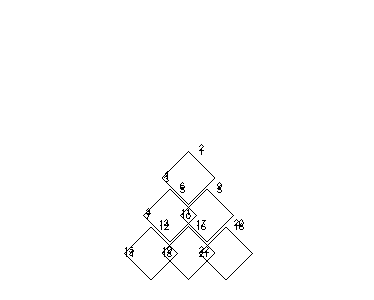

In [18]:
import turtle
import math
from PIL import Image
import IPython.display as display

class Square:
    def __init__(self, size, corners):
        self.size = size
        self.corners = corners

    def draw(self, x, y):
        turtle.penup()
        turtle.setpos(x, y)
        turtle.setheading(-45)
        turtle.pendown()
        for _ in range(4):
            turtle.forward(self.size)
            turtle.right(90)
        turtle.penup()

        x_offset = x
        y_offset = y
        angle = math.radians(-45)
        x_corner = x_offset + self.size * math.cos(angle) / 2
        y_corner = y_offset + self.size * math.sin(angle) / 2
        turtle.setpos(x_corner, y_corner + 10)
        turtle.write(str(self.corners[0]), align='center', font=('Arial', 12, 'normal'))

        x_corner = x_offset + self.size * math.cos(angle) / 2
        y_corner = y_offset - self.size * math.sin(angle) / 2
        turtle.setpos(x_corner, y_corner - 20)
        turtle.write(str(self.corners[1]), align='center', font=('Arial', 12, 'normal'))

        x_corner = x_offset + self.size * math.cos(angle) / 2 + self.size * math.sin(angle)
        y_corner = y_offset + self.size * math.sin(angle) / 2 - self.size * math.cos(angle)
        turtle.setpos(x_corner - 10, y_corner + 10)
        turtle.write(str(self.corners[2]), align='center', font=('Arial', 12, 'normal'))

        x_corner = x_offset + self.size * math.cos(angle) / 2 + self.size * math.sin(angle)
        y_corner = y_offset - self.size * math.sin(angle) / 2 - self.size * math.cos(angle)
        turtle.setpos(x_corner - 10, y_corner - 20)
        turtle.write(str(self.corners[3]), align='center', font=('Arial', 12, 'normal'))

def draw_pyramid(structure):
    turtle.speed(0)
    turtle.hideturtle()
    turtle.bgcolor('white')

    height = len(structure)
    size = 50
    y = 0

    for row in range(height):
        x = -row * size / 2
        for col in range(row + 1):
            corners = structure[row][col]
            square = Square(size, corners)
            square.draw(x, y)
            x += size
        y -= size
    
    # Get the bounds of the drawn content
    #x_min, y_min, x_max, y_max = turtle.Screen().screensize()
    #image_width = int(math.ceil(x_max - x_min))
    #image_height = int(math.ceil(y_max - y_min))

    image_width, image_height = turtle.Screen().screensize()

    # Create a new turtle screen with the adjusted canvas size
    canvas = turtle.getscreen().getcanvas()
    turtle.Screen().screensize(image_width, image_height)
    turtle.Screen().setup(image_width + 100, image_height + 100)

    # Save the image as PNG
    canvas.postscript(file='pyramid.eps', colormode='color')
    img = Image.open('pyramid.eps')
    img.save('pyramid.png', 'png')

    # Display the image inline
    display.display(display.Image('pyramid.png'))

# Example usage
#h_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) 
#structure = create_sub_vectors(h_values)
structure = [
    [(1, 2, 3, 4)],
    [(5, 6, 7, 8), (5, 9, 10, 11)],
    [(12, 13, 14, 15), (16, 17, 18, 19), (16, 20, 21, 22)]]
draw_pyramid(structure)
turtle.bye()

In [23]:
turtle.bye()
h_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) 
structure1 = create_sub_vectors(h_values)
structure = [
    [(1, 2, 3, 4)],
    [(5, 6, 7, 8), (5, 9, 10, 11)],
    [(12, 13, 14, 15), (16, 17, 18, 19), (16, 20, 21, 22)]]
print(structure1)
print(structure)

[[array([0, 4, 5, 9]), array([ 1,  5,  6, 10]), array([ 2,  6,  7, 11]), array([ 3,  7,  8, 12])], [array([ 5,  9, 10, 13]), array([ 6, 10, 11, 14]), array([ 7, 11, 12, 15])], [array([10, 13, 14, 16]), array([11, 14, 15, 17])], [array([14, 16, 17, 18])]]
[[(1, 2, 3, 4)], [(5, 6, 7, 8), (5, 9, 10, 11)], [(12, 13, 14, 15), (16, 17, 18, 19), (16, 20, 21, 22)]]
